In [1]:
# on colab run this then restart runtime to ensure matplotlib is updated
 
!pip install matplotlib --upgrade
!pip install xgboost --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 8.0 MB/s 
     |████████████████████████████████| 959 kB 57.2 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 255.9 MB 51 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import pandas as pd
import requests
import io
import pickle
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import (confusion_matrix,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             balanced_accuracy_score,
                             matthews_corrcoef,
                             roc_auc_score,
                             average_precision_score,
                             roc_curve,
                             precision_recall_curve
                             )


sns.set_style("whitegrid")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Functions

In [45]:
# plotting functions

def small_hist_plot(data, title=False):
  plt.rcParams['figure.figsize']=(6,4)
  g = sns.histplot(data, bins=30, linewidth=0.5)
  if title:
    g.set(title=title)

def ROC_plot(y_obs, y_pred):
  plt.rcParams['figure.figsize']=(6,4)
  fpr, tpr, thresholds = metrics.roc_curve(y_obs, y_pred, pos_label=1)
  plt.plot(fpr, tpr)
  plt.axline([0,0], slope=1, c="black")
  plt.text(.6, .2, f"AUC-ROC: {metrics.auc(fpr, tpr):.03f}") 
  plt.show()
  return(pd.DataFrame({'fpr': fpr, 'tpr' : tpr, 'thresh' :thresholds}))

def PR_plot(y_obs, y_pred):
  plt.rcParams['figure.figsize']=(6,4)
  precision, recall, thresholds = metrics.precision_recall_curve(y_obs, y_pred, pos_label=1)
  plt.plot(recall, precision)
  plt.text(.6, .2, f"AUC-PR: {metrics.average_precision_score(y_obs, y_pred, average='micro'):.03f}") 
  plt.show()
  return(pd.DataFrame({'precision': precision, 'recall' : recall}))

## load training data

In [2]:
data_path = "/content/drive/My Drive/local_data/m6A-calling/more_new/m6A_train_large.pkl"

#train_val_data = np.load(data_path, allow_pickle=True)

# Get the dictionary from the containing relevant data
#train_val_data = train_val_data['save_data_dict'][()]
train_val_data = pickle.load(open(data_path, "rb"))


In [3]:

# Load training and validation features and labels
X_train = train_val_data['X_train']
y_train = train_val_data['y_train']
X_val = train_val_data['X_val']
y_val = train_val_data['y_val']


X_train_2d = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_val_2d = X_val.reshape(X_val.shape[0], X_val.shape[1] * X_val.shape[2])



dval = xgb.DMatrix(X_val_2d, y_val)
dtrain = xgb.DMatrix(X_train_2d, y_train)



### Re-organize train and test so all CCSs are together

In [4]:


X_all = np.concatenate((X_train, X_val), axis=0)
y_all = np.concatenate((y_train, y_val), axis=0)

ccs_all = np.concatenate((train_val_data['train_final_ccss'], train_val_data['val_final_ccss']), axis=0)
pos_all = np.concatenate((train_val_data['train_final_m6a_call_positions'], train_val_data['val_final_m6a_call_positions']), axis=0)

unique_ccs = np.unique(ccs_all)
np.random.seed(42)
np.random.shuffle(unique_ccs)

split_point = int(unique_ccs.shape[0] * 0.75)
# train_ccs = unique_ccs[0:split_point]
# val_ccs = unique_ccs[split_point:]


# this way is really slow :(
# mask = np.array([ccs in train_ccs for ccs in ccs_all]) 


In [5]:
train_split = 0.75
split_point = int(unique_ccs.shape[0] * train_split)

# create a boolean mask for the 'all' data where True is training, and False is validation
ccs_zip = zip(unique_ccs, ['train']*split_point + ['val']*(unique_ccs.shape[0] - split_point)  )
train_dict = {ccs : value for ccs, value in ccs_zip}
mask = np.array([train_dict[ccs] == 'train' for ccs in   ccs_all], dtype=bool)

In [6]:
X_train = X_all[mask, :,:]
X_val = X_all[~mask, :,:]

y_train = y_all[mask, ]
y_val = y_all[~mask, ]

ccs_train = ccs_all[mask]
ccs_val = ccs_all[~mask]

pos_train = pos_all[mask]
pos_val = pos_all[~mask]


X_train_2d = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_val_2d = X_val.reshape(X_val.shape[0], X_val.shape[1] * X_val.shape[2])

dval = xgb.DMatrix(X_val_2d, y_val)
dtrain = xgb.DMatrix(X_train_2d, y_train)



## Train the model

In [ ]:
params = {'max_depth':6, 'objective':'binary:logistic', 'eval_metric':'auc'}

model = xgb.train(params, dtrain, num_boost_round=100)

In [ ]:
# don't run without updating the name
# model.save_model("/content/drive/My Drive/local_data/m6A-calling/models/xgboost_singlesub_more10.json")

## load existing model

In [7]:
model = xgb.Booster({'nthread': 4})  # init model
model.load_model("/content/drive/My Drive/local_data/m6A-calling/models/xgboost_singlesub_more10.json")  # load data

## test the model on single subreads

In [64]:
# score validation data

y_pred = model.predict(dval)
y_pred = y_pred[:, 0]

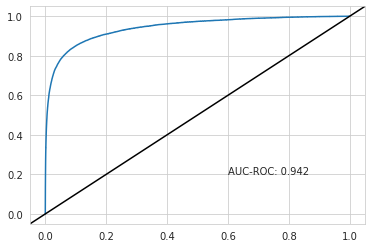

,fpr,tpr,thresh
8366,0.049988,0.781205,0.126421
10598,0.100030,0.849951,0.059305


In [65]:
temp = ROC_plot(y_obs, y_pred)

# show tpr and threshold at 5% and 1% fdr
pd.concat([ temp.iloc[(temp['fpr']-0.05).abs().argsort()[:1]],
            temp.iloc[(temp['fpr']-0.01).abs().argsort()[:1]] ])

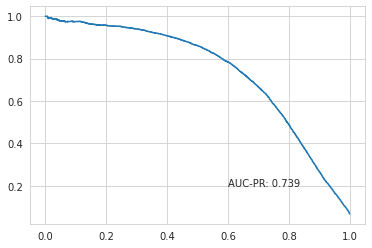

In [66]:
# AU-PR curve 
temp = PR_plot(y_obs, y_pred)

In [67]:
TP_preds = y_pred[y_obs==1]
TN_preds = y_pred[y_obs==0]

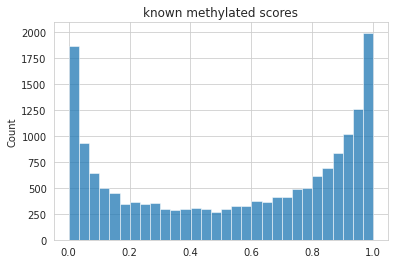

In [68]:
small_hist_plot(TP_preds, "known methylated scores")

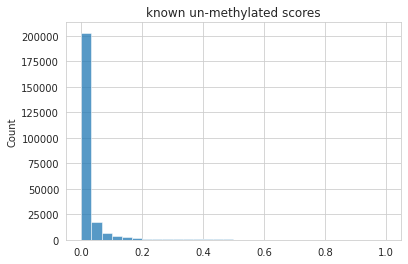

In [69]:
small_hist_plot(TN_preds, "known un-methylated scores")

## Make dataframe of predictions on validation data

In [70]:
pred_df = pd.DataFrame(data={'y_pred' : y_pred, 
                             'y_obs' : y_obs, 
                             'ccs' : ccs_val,
                             'pos' : pos_val
                             })


## check how correlated subreads at the same position are

In [71]:
multi_pred = pred_df.groupby(['ccs', 'pos']).agg({
    'y_pred' : ['first', 'last'],
    'y_obs' : 'first',
    'pos' : 'count'})

multi_pred = multi_pred[multi_pred['pos']['count'] > 1]

In [72]:
multi_pred = multi_pred[multi_pred['pos']['count'] > 1]
multi_pred.columns = multi_pred.columns.map('_'.join)

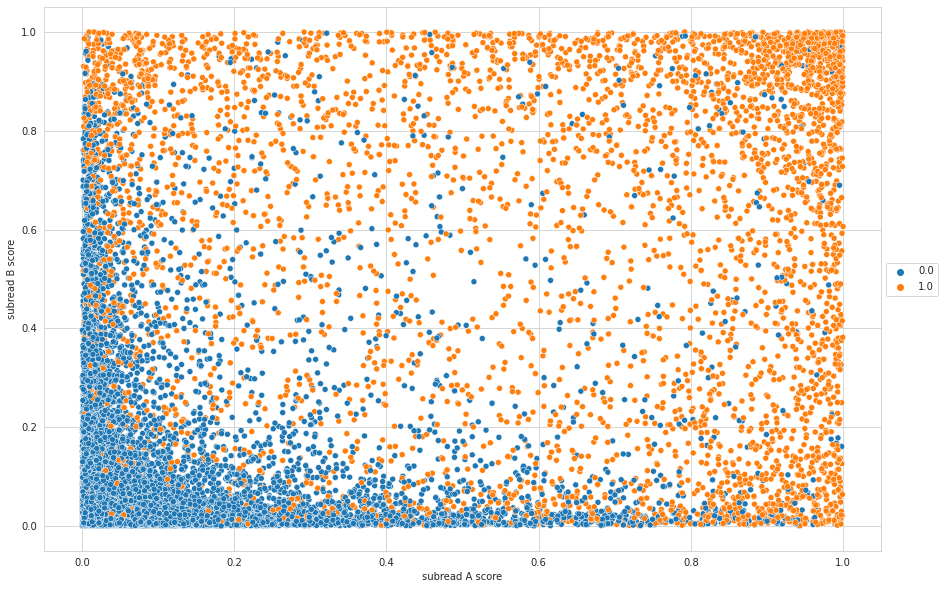

In [74]:
plt.rcParams['figure.figsize']=(15,10)

ax = sns.scatterplot(data=multi_pred, x='y_pred_first', y='y_pred_last', hue='y_obs_first')
ax.set(xlabel='subread A score', ylabel='subread B score')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)


In [75]:
# R^2 of scores of 2 subreads at same position
np.corrcoef(x=np.array(multi_pred['y_pred_first']), 
            y=np.array(multi_pred['y_pred_last']))[0,1] ** 2

0.3656519890525946

## kernel_density of TP and TN distributions 

needed for calculation of bayesian score

In [76]:
from sklearn.neighbors import KernelDensity

# use predictions on training data to make these
# ideally these would be made with a set that is not used 
# in training but also not part of validation

train_pred = model.predict(dtrain)
train_pred = train_pred[:, 0]

train_obs = y_train[:, 0]


TP_preds = train_pred[train_obs==1]
TN_preds = train_pred[train_obs==0]

bw = 0.008
kern = "gaussian" # slower because infinite support
# kern = "epanechnikov"

TP_kde = KernelDensity(kernel=kern, bandwidth=bw).fit(TP_preds.reshape(-1,1))
TN_kde = KernelDensity(kernel=kern, bandwidth=bw).fit(TN_preds[0:200000].reshape(-1,1))

In [79]:
decimal_places = 3
step_size = np.round(10**-decimal_places, decimal_places)



x = np.arange(0, 1+step_size, step_size)

x_int = np.array(x * 10**decimal_places, dtype=int)

y_TP = np.exp(TP_kde.score_samples(x.reshape(-1,1)))

y_TN = np.exp(TN_kde.score_samples(x.reshape(-1,1)))

TP_PDF_lookup = {x_int[i] : y_TP[i] for i in range(len(x))}

TN_PDF_lookup = {x_int[i] : y_TN[i] for i in range(len(x))}

In [80]:

TP_data = pd.DataFrame({
    'x' : x,
    'y' : y_TP,
    'label' : "TP"
})

TN_data = pd.DataFrame({
    'x' : x,
    'y' : y_TN,
    'label' : "TN"
})

plot_data = pd.concat([TP_data, TN_data], ignore_index=True)

(0.0, 6.0)

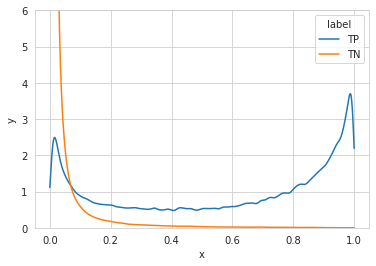

In [81]:
plt.rcParams['figure.figsize']=(6,4)

sns.lineplot(data=plot_data, x="x", y="y", hue='label')

# plt.xlim([-0.01,0.02])
# plt.xlim([0.98,1.02])

plt.ylim([0,6])

In [82]:
# add PDF lookup values to single subread validation predictions

pred_df['TP_likelyhood'] = [TP_PDF_lookup[np.round(score, decimal_places)] for score in np.array(pred_df['y_pred'] * 10**decimal_places, dtype=int) ]
pred_df['TN_likelyhood'] = [TN_PDF_lookup[np.round(score, decimal_places)] for score in np.array(pred_df['y_pred'] * 10**decimal_places, dtype=int) ]

## calculate mean and bayesian aggregate scores

In [83]:
# this step aggregates by ccs and positon. and calculates both the mean score, and the product of PDF values needed for the bayesian score

pred_product = pred_df.groupby(['ccs', 'pos']).agg({
    'y_pred' : 'mean',
    'y_obs' : 'first',
    'TP_likelyhood' : np.prod,
    'TN_likelyhood' : np.prod,
    'pos' : 'count'})

# pred_product

In [84]:
# assign the prior expectation of a site being methylated or not

P_TP = 0.06449
# P_TP = 0.5 # what if we lack prior knowledge or our estimate is off?
P_TN = 1 - P_TP

In [85]:
pred_product['bayesian_score'] = P_TP * pred_product['TP_likelyhood'] / ( P_TP * pred_product['TP_likelyhood'] + P_TN * pred_product['TN_likelyhood']  )
# pred_product

## filter pred_product 

if we want to look at only instances with certain numbers of subreads

In [86]:
pred_prod_filt = pred_product[pred_product['pos'] > 0]
# pred_prod_filt

# evaluate mean score

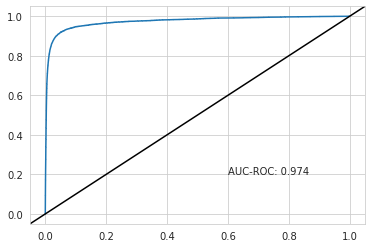

,fpr,tpr,thresh
2477,0.050061,0.918533,0.134855
1253,0.010003,0.771271,0.344781


In [94]:
y_pred_new = np.array(pred_prod_filt['y_pred'])
y_obs_new = np.array(pred_prod_filt['y_obs'])
temp = ROC_plot(y_obs_new, y_pred_new)

# show tpr and threshold at 5% and 1% fdr
pd.concat([ temp.iloc[(temp['fpr']-0.05).abs().argsort()[:1]],
            temp.iloc[(temp['fpr']-0.01).abs().argsort()[:1]] ])


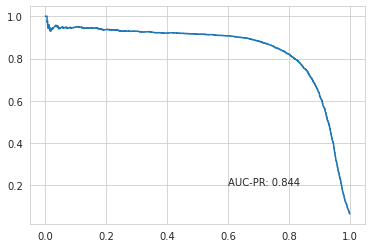

In [88]:
temp = PR_plot(y_obs_new, y_pred_new)

In [89]:
TP_preds = y_pred_new[y_obs_new==1]
TN_preds = y_pred_new[y_obs_new==0]

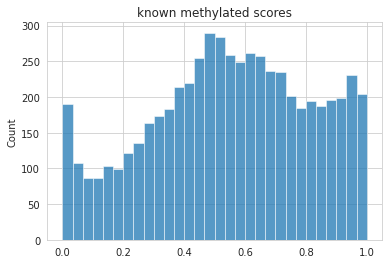

In [90]:
small_hist_plot(TP_preds, "known methylated scores")

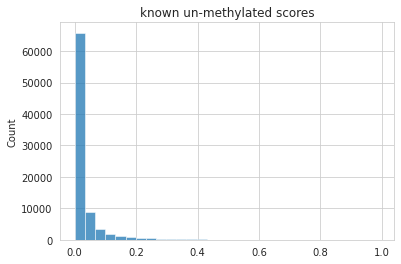

In [91]:
small_hist_plot(TN_preds, "known un-methylated scores")

# evaluate bayesian score

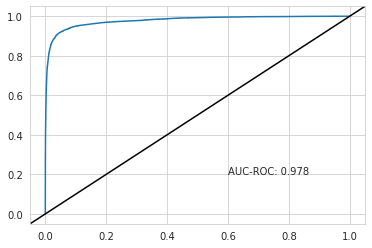

,fpr,tpr,thresh
2501,0.049965,0.919910,0.067839
1237,0.009991,0.792801,0.665606


In [98]:
y_pred_new = np.array(pred_prod_filt['bayesian_score'])
y_obs_new = np.array(pred_prod_filt['y_obs'])
temp = ROC_plot(y_obs_new, y_pred_new)

# show tpr and threshold at 5% and 1% fdr
pd.concat([ temp.iloc[(temp['fpr']-0.05).abs().argsort()[:1]],
            temp.iloc[(temp['fpr']-0.01).abs().argsort()[:1]] ])



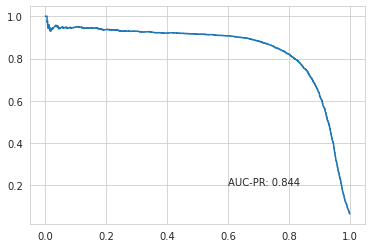

In [95]:
temp = PR_plot(y_obs_new, y_pred_new)

In [99]:
TP_preds = y_pred_new[y_obs_new==1]
TN_preds = y_pred_new[y_obs_new==0]

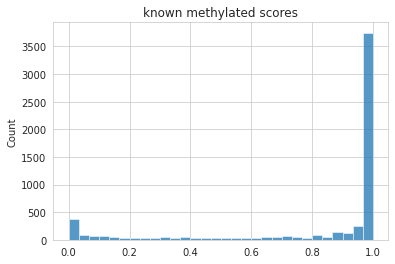

In [100]:
small_hist_plot(TP_preds, "known methylated scores")

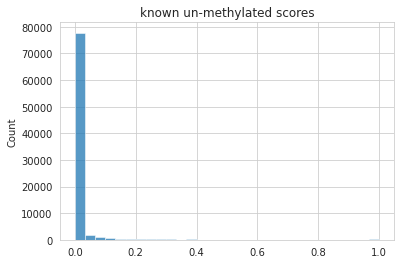

In [101]:
small_hist_plot(TN_preds, "known un-methylated scores")

## plot comparison of mean to bayesian score

[Text(0.5, 0, 'mean score'), Text(0, 0.5, 'bayesian score')]

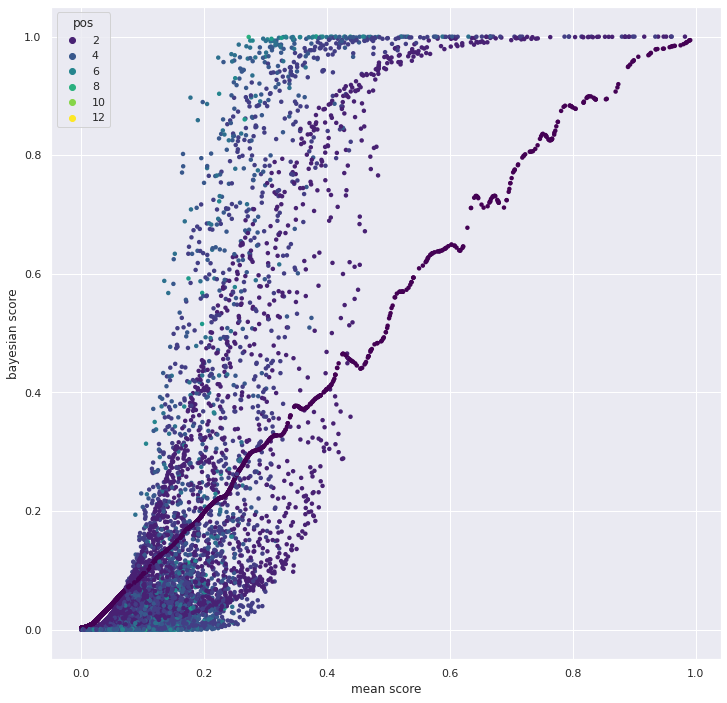

In [102]:
plt.rcParams['figure.figsize']=(12,12)

# pred_prod_filt['true_label'] = np.array(pred_prod_filt['y_obs'], dtype=bool)
sns.set(style="darkgrid")
ax = sns.scatterplot(data=pred_prod_filt[pred_prod_filt['y_obs'] == False ], x='y_pred', y='bayesian_score', 
                     hue='pos', palette = sns.color_palette("viridis", as_cmap=True),
                     linewidth=0, s=20)
# ax = sns.jointplot(data=pred_prod_filt, x='y_pred', y='bayesian_score')

ax.set(xlabel='mean score', ylabel='bayesian score')
# plt.xlim([0, 0.2])
# plt.ylim([0, 0.2])


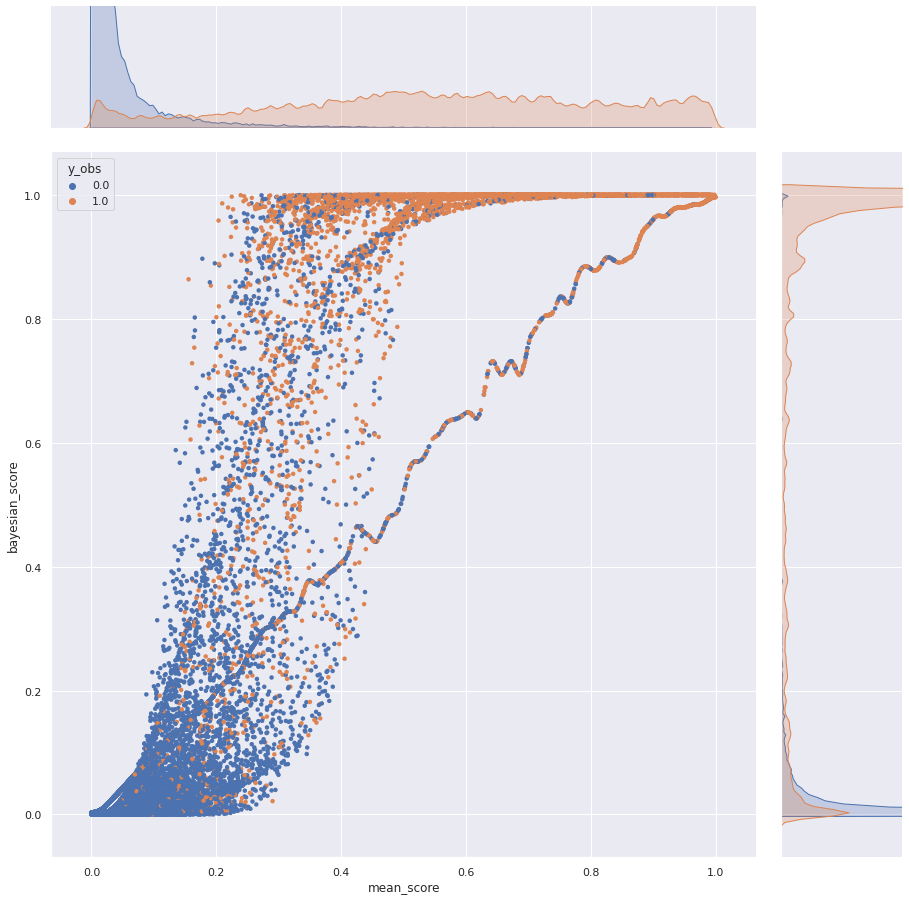

In [103]:
plt.rcParams['figure.figsize']=(15,20)

g = sns.JointGrid(data=pred_prod_filt, x='y_pred', y='bayesian_score', hue='y_obs', height=12)
g.plot_joint(sns.scatterplot, linewidth=0, s=20)

for k in [0,1]:
    data = pred_prod_filt[pred_prod_filt.y_obs == k]
    sns.kdeplot(x=data.y_pred, fill=True, label=k, ax=g.ax_marg_x, bw_adjust = 0.1, common_norm=False, common_grid=False)
    sns.kdeplot(y=data.bayesian_score, fill=True, label=k, ax=g.ax_marg_y, bw_adjust = 0.1, common_norm=False, common_grid=False)

# g.ax_marg_y.set_xlim(0,25)
# g.ax_marg_x.set_ylim(0,5)

g.ax_marg_y.set_xlim(0,5)
g.ax_marg_x.set_ylim(0,5)

plt.gcf().subplots_adjust(bottom=0)
plt.gcf().subplots_adjust(left=0)

g.set_axis_labels('mean_score', 'bayesian_score')